In [1]:
with open('./function/requirements_import.py') as f:
    exec(f.read())

In [2]:
class_weights = {0: 0.12, 1: 6.3, 2: 3.99, 3: 4.63, 4: 4.28, 5: 3.43, 6: 5.15, 7: 6.85, 8: 17.79, 9: 20.86}

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )

# 시계열 데이터 이미지화 데이터 로드

In [3]:
file_path = './data/rainfall_train_prep.csv'
rainfall3 = pd.read_csv(file_path)
rainfall3 = rainfall3.drop(['vv'], axis=1)

rainfall3['timestamp_log'] = np.log(rainfall3['timestamp'])
rainfall3 = rainfall3.drop(columns=['ef_day_y', 'timestamp', 'ef_year'])
print(rainfall3.shape) #1457432

idx = rainfall3[rainfall3['dh'] == 3].index
idx = idx-1
idx = idx[1:]

temp = rainfall3.iloc[idx]
temp = temp.reset_index(drop=True)
idx = temp[temp['dh'] != 240].index

val = temp.iloc[idx, :5].values
result = []

for temp3 in val:
    e, a, b, c, d = temp3
    temp2 = rainfall3[(rainfall3['fc_year'] == e) & (rainfall3['fc_month'] == a) & (rainfall3['fc_day'] == b) & (rainfall3['fc_hour'] == c) & (rainfall3['stn4contest'] == d)].index
    result += list(temp2)
    
rainfall = rainfall3.drop(result)
rainfall.shape #1452720

(1457432, 33)


(1452720, 33)

In [4]:
rainfall = rainfall.reset_index(drop=True)
idx = rainfall[rainfall['dh'] == 3].index
idx = idx-1
idx = idx[1:]

#---------------------------------#

rainfall2 = rainfall.drop(columns= list(rainfall.columns[:9]) + ['timestamp_log', 'fc_day_y'])
temp = rainfall2.iloc[idx]
aa = temp.iloc[:int(len(idx) *0.7)].index[-1]
bb = temp.iloc[:int(len(idx) *0.7) + int((len(idx)-int(len(idx) *0.7)) *0.7)].index[-1]

target = 'class_interval'
x = rainfall2.drop(target, axis=1)
y = rainfall2.loc[:, target]

#---------------------------------#

x_train = x.iloc[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x.iloc[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x.iloc[bb+1:]
y_test = y.iloc[bb+1:]

# Model

## GASF

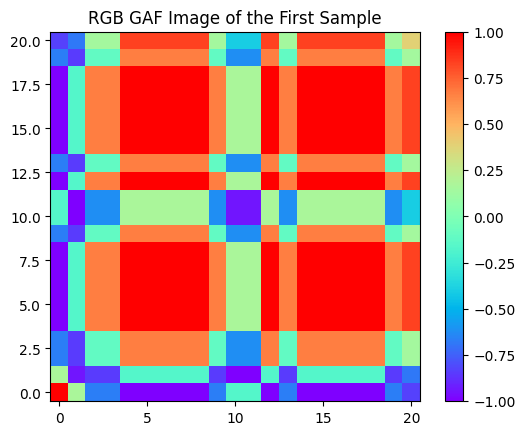

In [5]:
gaf = GramianAngularField(method='summation')
x_train_gaf = gaf.fit_transform(x_train)
x_val_gaf = gaf.transform(x_val)
x_test_gaf = gaf.transform(x_test)

plt.imshow(x_train_gaf[11], cmap='rainbow', origin='lower')
plt.title('RGB GAF Image of the First Sample')
plt.colorbar()
plt.show()

In [6]:
x_train_gaf.shape, x_val_gaf.shape, x_test_gaf.shape

((1016800, 21, 21), (305040, 21, 21), (130880, 21, 21))

In [8]:
y_train.shape, y_val.shape, y_test.shape

((1016800,), (305040,), (130880,))

In [14]:
x_train_gaf4 = x_train_gaf.reshape(-1, 21, 21, 1)
x_val_gaf4= x_val_gaf.reshape(-1, 21, 21, 1)
x_test_gaf4= x_test_gaf.reshape(-1, 21, 21, 1)

In [27]:
# 0610_18:00기준 best
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_sch = LearningRateScheduler(scheduler)
es.monitor='val_loss'
es.patience=10

# 학습
history = model.fit(x_train_gaf4, y_train, epochs = 30, callbacks=[lr_sch], validation_data=(x_val_gaf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_gaf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,647,850 (6.29 MB)

 Trainable params: 1,647,850 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 239s 18ms/step - accuracy: 0.4577 - loss: 2.2065 - val_accuracy: 0.3985 - val_loss: 1.2428 - learning_rate: 3.6788e-04
Epoch 2/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 235s 18ms/step - accuracy: 0.4873 - loss: 1.8304 - val_accuracy: 0.4795 - val_loss: 1.1544 - learning_rate: 3.3287e-04
Epoch 3/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 230s 18ms/step - accuracy: 0.5078 - loss: 1.7685 - val_accuracy: 0.4537 - val_loss: 1.1608 - learning_rate: 3.2956e-04
Epoch 4/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 231s 18ms/step - accuracy: 0.5039 - loss: 1.7368 - val_accuracy: 0.4496 - val_loss: 1.1673 - learning_rate: 3.2923e-04
Epoch 5/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 233s 18ms/step - accuracy: 0.4999 - loss: 1.7156 - val_accuracy: 0.4407 - val_loss: 1.1811 - learning_rate: 3.2920e-04
Epoch 6/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 233s 18ms/step - accuracy: 0.5004 - loss: 1.6990 - val_accuracy: 0.4322 - val_loss: 1.1824 - learning_rate: 3.2919e-04
Epoch 7/300
1271

KeyboardInterrupt: 

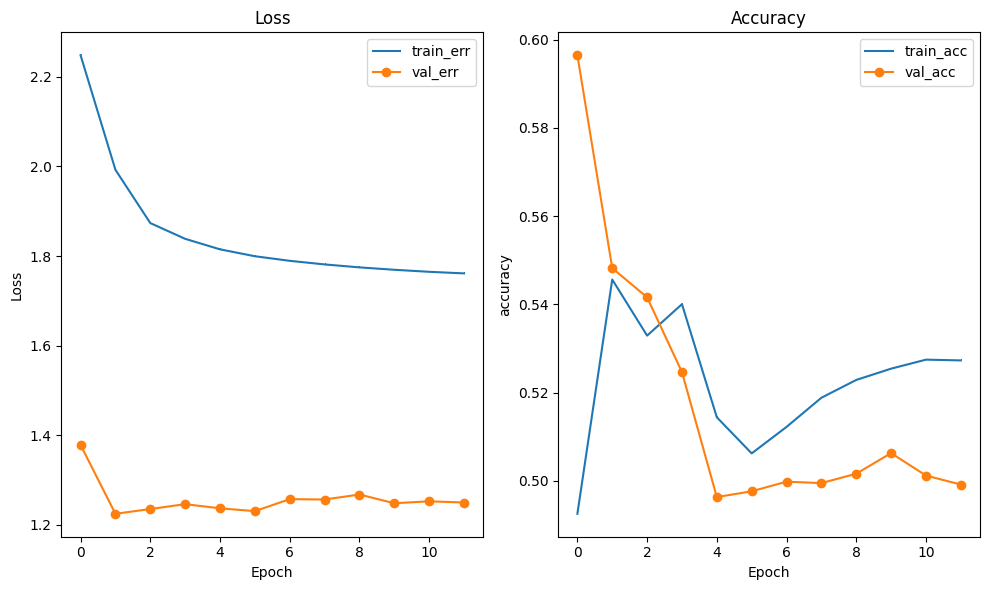

In [17]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

## GADF

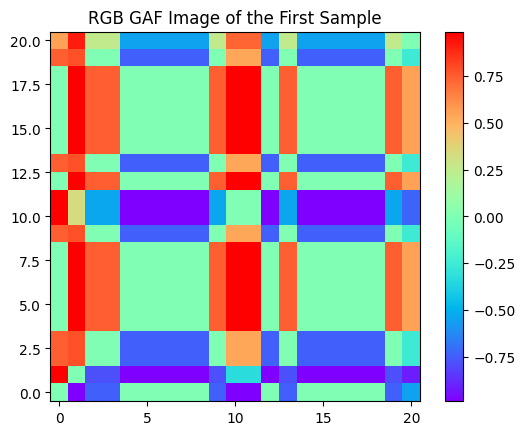

gaf :  (1016800, 21, 21) (305040, 21, 21) (130880, 21, 21)
y :  (1016800,) (305040,) (130880,)


In [28]:
gaf = GramianAngularField(image_size=21, method='difference')
x_train_gaf = gaf.fit_transform(x_train)
x_val_gaf = gaf.transform(x_val)
x_test_gaf = gaf.transform(x_test)

plt.imshow(x_train_gaf[11], cmap='rainbow', origin='lower')
plt.title('RGB GAF Image of the First Sample')
plt.colorbar()
plt.show()

print('gaf : ', x_train_gaf.shape, x_val_gaf.shape, x_test_gaf.shape)
print('y : ', y_train.shape, y_val.shape, y_test.shape)

In [30]:
x_train_gaf4 = x_train_gaf.reshape(-1, 21, 21, 1)
x_val_gaf4= x_val_gaf.reshape(-1, 21, 21, 1)
x_test_gaf4= x_test_gaf.reshape(-1, 21, 21, 1)

In [31]:
# 0610_18:00기준 best
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_sch = LearningRateScheduler(scheduler)
es.monitor='val_loss'
es.patience=10

# 학습
history = model.fit(x_train_gaf4, y_train, epochs = 30, callbacks=[lr_sch], validation_data=(x_val_gaf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_gaf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,647,850 (6.29 MB)

 Trainable params: 1,647,850 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 226s 18ms/step - accuracy: 0.4145 - loss: 2.2151 - val_accuracy: 0.4560 - val_loss: 1.1941 - learning_rate: 3.6788e-04
Epoch 2/30
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 266s 21ms/step - accuracy: 0.4899 - loss: 1.8409 - val_accuracy: 0.4642 - val_loss: 1.1733 - learning_rate: 3.3287e-04
Epoch 3/30
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 258s 20ms/step - accuracy: 0.4931 - loss: 1.7849 - val_accuracy: 0.4755 - val_loss: 1.1651 - learning_rate: 3.2956e-04
Epoch 4/30
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 262s 21ms/step - accuracy: 0.5031 - loss: 1.7550 - val_accuracy: 0.4742 - val_loss: 1.1801 - learning_rate: 3.2923e-04
Epoch 5/30
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 249s 20ms/step - accuracy: 0.5079 - loss: 1.7344 - val_accuracy: 0.4878 - val_loss: 1.1642 - learning_rate: 3.2920e-04
Epoch 6/30
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 279s 22ms/step - accuracy: 0.5104 - loss: 1.7173 - val_accuracy: 0.5015 - val_loss: 1.1226 - learning_rate: 3.2919e-04
Epoch 7/30
12710/12710

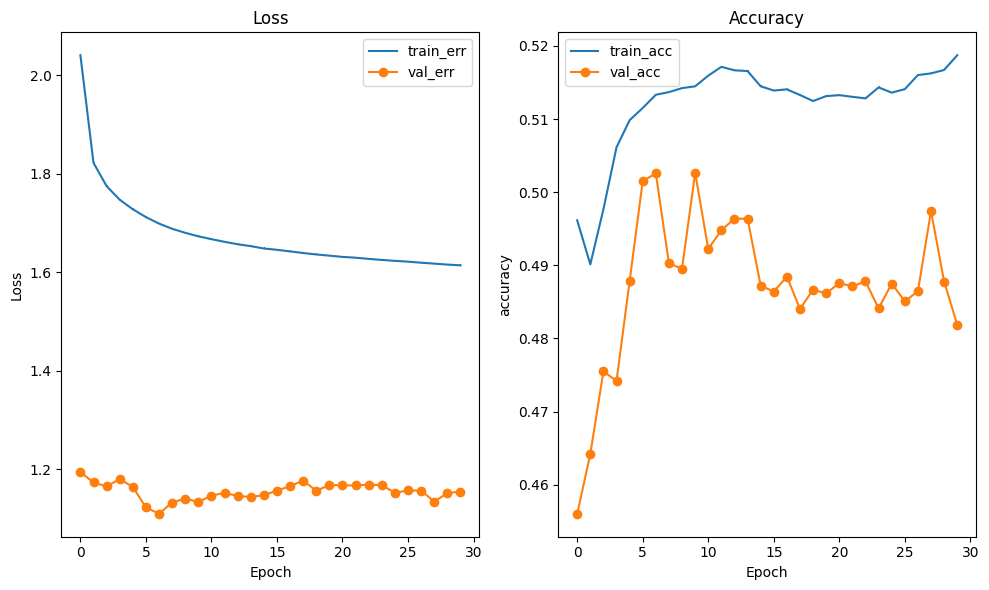

In [32]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

## MTF

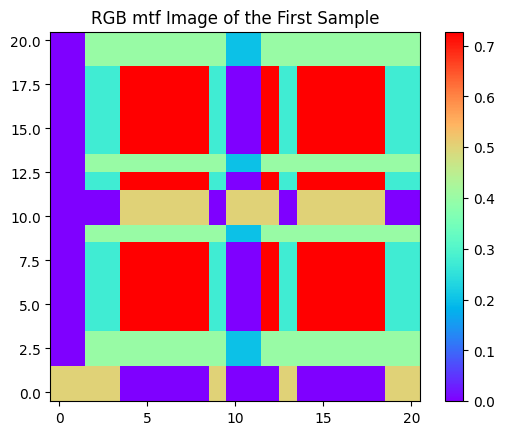

mtf :  (1016800, 21, 21) (1321840, 21, 21) (130880, 21, 21)
y :  (1016800,) (1321840,) (130880,)


In [6]:
mtf = MarkovTransitionField(image_size=21)
x_train_mtf = mtf.fit_transform(x_train)
x_val_mtf = mtf.transform(x_val)
x_test_mtf = mtf.transform(x_test)

plt.imshow(x_train_mtf[11], cmap='rainbow', origin='lower')
plt.title('RGB mtf Image of the First Sample')
plt.colorbar()
plt.show()

print('mtf : ', x_train_mtf.shape, x_val_mtf.shape, x_test_mtf.shape)
print('y : ', y_train.shape, y_val.shape, y_test.shape)

In [8]:
x_train_mtf4 = x_train_mtf.reshape(-1, 21, 21, 1)
x_val_mtf4= x_val_mtf.reshape(-1, 21, 21, 1)
x_test_mtf4= x_test_mtf.reshape(-1, 21, 21, 1)

# x_train_mtf4 = x_train_mtf / 255.
# x_val_mtf4 = x_val_mtf / 255.
# x_test_mtf4 = x_test_mtf / 255.

# x_train_mtf4 = x_train_mtf4.reshape(-1, 21, 21, 1)
# x_val_mtf4= x_val_mtf4.reshape(-1, 21, 21, 1)
# x_test_mtf4= x_test_mtf4.reshape(-1, 21, 21, 1)

In [9]:
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_mtf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train_mtf4, y_train, epochs = 10, callbacks=[lr_sch], validation_data=(x_val_mtf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_mtf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - accuracy: 0.3495 - csi_metric: 0.0165 - loss: 2.3777 - val_accuracy: 0.4704 - val_csi_metric: 0.0120 - val_loss: 1.7002 - learning_rate: 3.6788e-04
Epoch 2/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 125s 10ms/step - accuracy: 0.4635 - csi_metric: 0.0172 - loss: 2.2015 - val_accuracy: 0.4475 - val_csi_metric: 0.0184 - val_loss: 1.5523 - learning_rate: 3.3287e-04
Epoch 3/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - accuracy: 0.4433 - csi_metric: 0.0207 - loss: 2.1176 - val_accuracy: 0.4509 - val_csi_metric: 0.0191 - val_loss: 1.5207 - learning_rate: 3.2956e-04
Epoch 4/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 132s 10ms/step - accuracy: 0.4586 - csi_metric: 0.0209 - loss: 2.0849 - val_accuracy: 0.4595 - val_csi_metric: 0.0190 - val_loss: 1.4840 - learning_rate: 3.2923e-04
Epoch 5/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - accuracy: 0.4711 - csi_metric: 0.0208 - loss: 2.0617 - val_accuracy: 0.4593 - val_csi_metric: 0.0193 - 

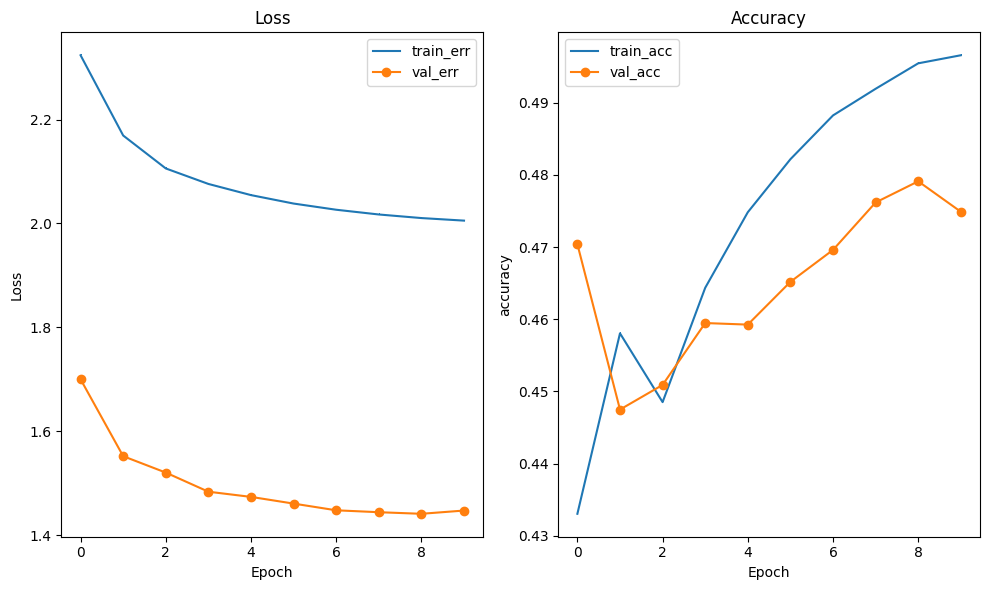

In [10]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [12]:
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_mtf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

lr_sch = LearningRateScheduler(scheduler)
es.patience = 20
es.monitor = 'val_accuracy'

# 학습
history = model.fit(x_train_mtf4, y_train, epochs = 300, callbacks=[lr_sch, es], validation_data=(x_val_mtf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_mtf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 124s 10ms/step - accuracy: 0.3186 - csi_metric: 0.0161 - loss: 2.3898 - val_accuracy: 0.4209 - val_csi_metric: 0.0115 - val_loss: 1.8148 - learning_rate: 3.6788e-04
Epoch 2/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 116s 9ms/step - accuracy: 0.4357 - csi_metric: 0.0130 - loss: 2.2990 - val_accuracy: 0.4553 - val_csi_metric: 0.0116 - val_loss: 1.7323 - learning_rate: 3.3287e-04
Epoch 3/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 114s 9ms/step - accuracy: 0.4556 - csi_metric: 0.0141 - loss: 2.2705 - val_accuracy: 0.4763 - val_csi_metric: 0.0128 - val_loss: 1.6838 - learning_rate: 3.2956e-04
Epoch 4/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 122s 10ms/step - accuracy: 0.4724 - csi_metric: 0.0156 - loss: 2.2431 - val_accuracy: 0.4690 - val_csi_metric: 0.0148 - val_loss: 1.6641 - learning_rate: 3.2923e-04
Epoch 5/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 122s 10ms/step - accuracy: 0.4695 - csi_metric: 0.0174 - loss: 2.2237 - val_accuracy: 0.4504 - val_csi_metric: 0.0166

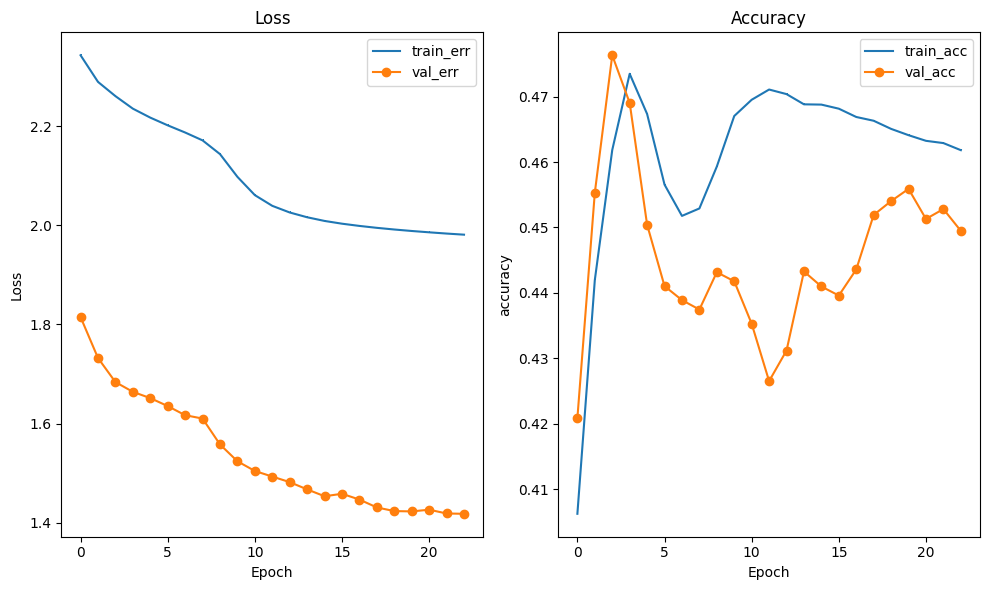

In [13]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

## GASF+GADF

In [5]:
gasf = GramianAngularField(method='summation')
x_train_gasf = gasf.fit_transform(x_train)
x_val_gasf = gasf.transform(x_val)
x_test_gasf = gasf.transform(x_test)

gadf = GramianAngularField(method='difference')
x_train_gadf = gadf.fit_transform(x_train)
x_val_gadf = gadf.transform(x_val)
x_test_gadf = gadf.transform(x_test)

In [9]:
x_train_gaf = np.concatenate((x_train_gasf,x_train_gadf,np.zeros(x_train_gadf.shape)),axis=-1)
x_val_gaf = np.concatenate((x_val_gasf,x_val_gadf,np.zeros(x_val_gadf.shape)),axis=-1)
x_test_gaf = np.concatenate((x_test_gasf,x_test_gadf,np.zeros(x_test_gadf.shape)),axis=-1)

plt.imshow(x_train_gaf[11], cmap='rainbow', origin='lower')
plt.title('RGB GAF Image of the First Sample')
plt.colorbar()
plt.show()

print('gaf : ', x_train_gaf.shape, x_val_gaf.shape, x_test_gaf.shape)
print('y : ', y_train.shape, y_val.shape, y_test.shape)

MemoryError: Unable to allocate 3.34 GiB for an array with shape (1016800, 21, 21) and data type float64

In [ ]:
x_train_gaf4 = x_train_gaf.reshape(-1, 21, 21, 1)
x_val_gaf4= x_val_gaf.reshape(-1, 21, 21, 1)
x_test_gaf4= x_test_gaf.reshape(-1, 21, 21, 1)

In [ ]:
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train_gaf4, y_train, epochs = 10, callbacks=[lr_sch], validation_data=(x_val_gaf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_gaf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 190s 15ms/step - accuracy: 0.4344 - loss: 2.2793 - val_accuracy: 0.5218 - val_loss: 1.2840
Epoch 2/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 163s 13ms/step - accuracy: 0.5250 - loss: 1.9136 - val_accuracy: 0.4498 - val_loss: 1.2574
Epoch 3/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 161s 13ms/step - accuracy: 0.5201 - loss: 1.8545 - val_accuracy: 0.4951 - val_loss: 1.2224
Epoch 4/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 162s 13ms/step - accuracy: 0.5294 - loss: 1.8263 - val_accuracy: 0.5011 - val_loss: 1.2148
Epoch 5/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 166s 13ms/step - accuracy: 0.5257 - loss: 1.8088 - val_accuracy: 0.4946 - val_loss: 1.2105
Epoch 6/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 164s 13ms/step - accuracy: 0.5253 - loss: 1.7942 - val_accuracy: 0.4988 - val_loss: 1.1992
Epoch 7/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 167s 13ms/step - accuracy: 0.5222 - loss: 1.7791 - val_accuracy: 0.4907 - val_loss: 1.2083
Epoch 8/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 151s 12ms/s

In [ ]:
# 주어진 데이터셋

model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(32, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])
# es = EarlyStopping(monitor='val_csi_metric',        # 얼리스토핑을 적용할 관측 지표
#                 min_delta=0,               # 임계값
#                 patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
#                 verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
#                 restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
#                 )
# 학습
history = model.fit(x_train_gaf4, y_train, epochs = 10, validation_data=(x_val_gaf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_gaf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
recall = recall_score(y_test, pred_1, average='macro')
print(cm,recall)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,082 (402.66 KB)

 Trainable params: 103,082 (402.66 KB)

 Non-trainable params: 0 (0.00 B)

12710/12710 ━━━━━━━━━━━━━━━━━━━━ 127s 10ms/step - accuracy: 0.4618 - csi_metric: 0.0164 - loss: 2.2604 - val_accuracy: 0.5230 - val_csi_metric: 0.0227 - val_loss: 1.2817
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


NameError: name 'np' is not defined

In [ ]:
import time
result = {}
for temp in [10, 16, 20, 40]:
    model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                        Conv2D(32, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                        MaxPooling2D(pool_size = 2 ),
                        Flatten(),
                        Dense(32, activation='relu'),
                        Dense(10, activation='softmax')])

    # 모델 설정
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

    # 학습
    model.fit(x_train_gaf4, y_train, epochs = 5, validation_data=(x_val_gaf4, y_val), batch_size=temp, class_weight=class_weights)

    # 예측
    pred = model.predict(x_test_gaf4)
    pred_1 = pred.argmax(axis=1)

    cm = confusion_matrix(y_test, pred_1)
    recall = recall_score(y_test, pred_1, average='macro')
    result[temp] = [csi(cm), recall]
    
    time.sleep(5)

beepsound()
result

Epoch 1/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 474s 5ms/step - accuracy: 0.4407 - csi_metric: 0.0176 - loss: 2.2510 - val_accuracy: 0.4023 - val_csi_metric: 0.0268 - val_loss: 1.2892
Epoch 2/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 449s 4ms/step - accuracy: 0.4204 - csi_metric: 0.0255 - loss: 1.9423 - val_accuracy: 0.3789 - val_csi_metric: 0.0318 - val_loss: 1.3312
Epoch 3/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 475s 5ms/step - accuracy: 0.4085 - csi_metric: 0.0291 - loss: 1.8872 - val_accuracy: 0.3771 - val_csi_metric: 0.0315 - val_loss: 1.3130
Epoch 4/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 460s 5ms/step - accuracy: 0.4086 - csi_metric: 0.0295 - loss: 1.8710 - val_accuracy: 0.3708 - val_csi_metric: 0.0322 - val_loss: 1.3213
Epoch 5/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 446s 4ms/step - accuracy: 0.4098 - csi_metric: 0.0297 - loss: 1.8604 - val_accuracy: 0.3704 - val_csi_metric: 0.0327 - val_loss: 1.3245
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Epoch 1/5
63550/63550 ━━━━━━━━━━━━━━━━━━━━ 355s 6ms/

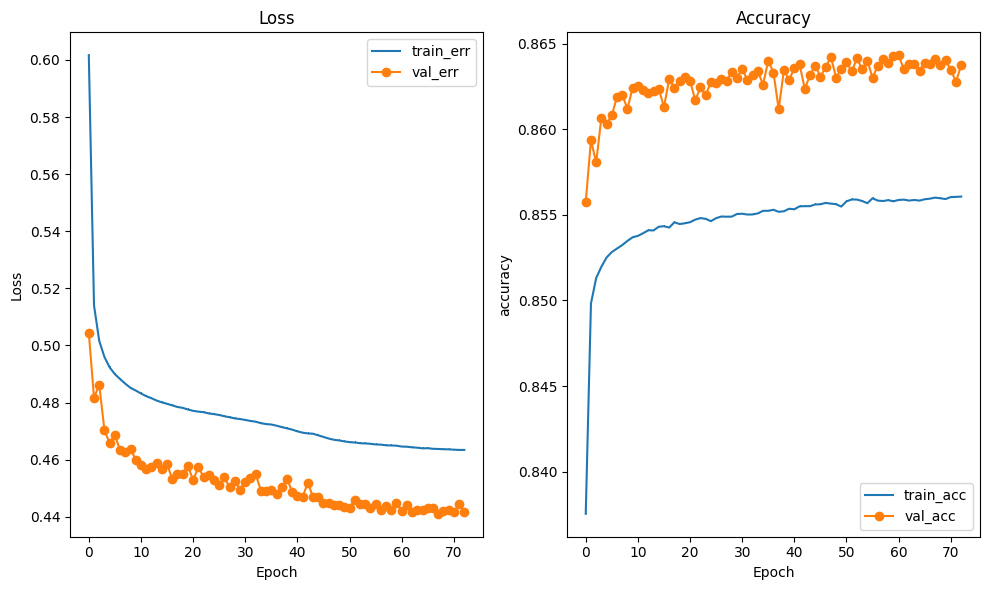

In [ ]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()